In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from utils import get_loaders
from models import SSLNet
from trainers import train_ssd
from evals import evaluate

print(torch.cuda.is_available())

True


In [13]:
config = {
    'method': 'ssd',
    'temperature': 0.07,
    'contrast_mode': 'one',
    
    # Training
    'epochs': 1000,
    'lr': 1e-4,
    'weight_decay': 1e-6,
    'patience': 20,
    'min_delta': 1e-8,
    'sched_patience': 10,
    'sched_factor': 0.5,
    
    # Network
    'dims' : [30, 16, 8],
    'drop': 0.1,
    'norm': True,
    'activation': 'ReLU',
    
    # Dataset
    'val_split': 0.1,
    'test_split': 0.1,
    'batch_size': 1024,
    
    # Utility
    'seed': 15,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'data_path': './Data/creditcard.csv',
    'print_freq': 5,
}

In [14]:
train_loader, val_loader, test_loader = get_loaders(config['data_path'], config['val_split'], config['test_split'], config['seed'], config['batch_size'], config['method'])

(230693, 31) (25633, 31) (28481, 31)


# Training

In [15]:
model = SSLNet(config).to(config['device'])
print(model)

config['temperature'] = 0.07
config['seed'] = 15

SSLNet(
  (embeddings): Sequential(
    (0): Linear(in_features=30, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
  )
)


In [16]:
model, train_losses, val_losses, train_ap, val_ap, train_fpr, val_fpr = train_ssd(model, train_loader, val_loader, config)

Epoch 1 | Train Loss: 5.5491 | Val Loss: 3.7535 | Train AUPRC: 0.0287 | Val AUPRC: 0.0571 | Train FPR@95TPR: 0.4912 | Val FPR@95TPR: 0.2500 | Best Epoch: 0
Epoch 5 | Train Loss: 4.5121 | Val Loss: 3.5101 | Train AUPRC: 0.0255 | Val AUPRC: 0.0517 | Train FPR@95TPR: 0.3033 | Val FPR@95TPR: 0.1591 | Best Epoch: 4
Epoch 10 | Train Loss: 4.2495 | Val Loss: 3.4246 | Train AUPRC: 0.0303 | Val AUPRC: 0.0439 | Train FPR@95TPR: 0.2982 | Val FPR@95TPR: 0.2045 | Best Epoch: 9
Epoch 15 | Train Loss: 4.1385 | Val Loss: 3.3747 | Train AUPRC: 0.0293 | Val AUPRC: 0.0315 | Train FPR@95TPR: 0.3083 | Val FPR@95TPR: 0.1591 | Best Epoch: 14
Epoch 20 | Train Loss: 4.0699 | Val Loss: 3.3354 | Train AUPRC: 0.0413 | Val AUPRC: 0.0401 | Train FPR@95TPR: 0.2607 | Val FPR@95TPR: 0.1136 | Best Epoch: 19
Epoch 25 | Train Loss: 4.0110 | Val Loss: 3.3127 | Train AUPRC: 0.0407 | Val AUPRC: 0.0601 | Train FPR@95TPR: 0.2155 | Val FPR@95TPR: 0.0682 | Best Epoch: 24
Epoch 30 | Train Loss: 3.9664 | Val Loss: 3.2948 | Train 

KeyboardInterrupt: 

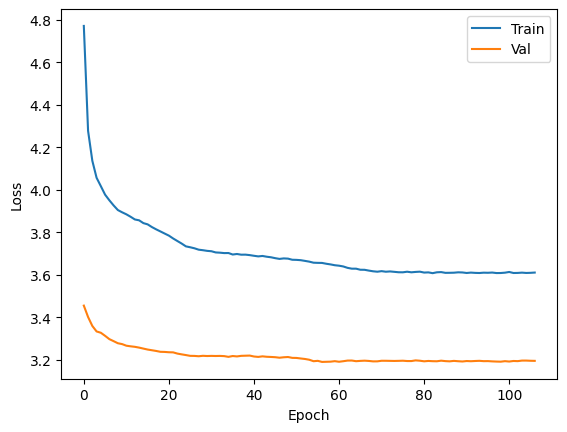

In [17]:
# Plot the loss
plt.plot(train_losses, label = "Train")
plt.plot(val_losses, label = "Val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

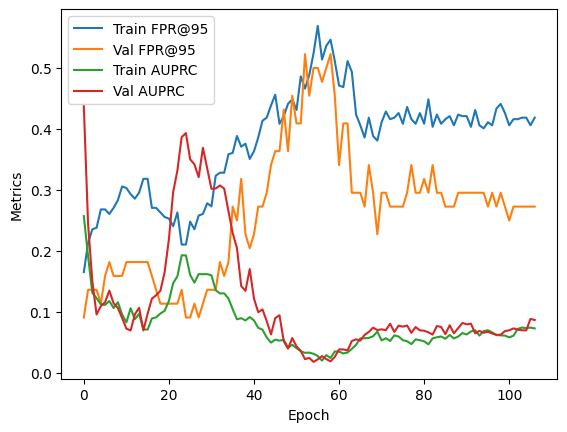

In [18]:
#Plot the metrics
plt.plot(train_fpr, label = "Train FPR@95")
plt.plot(val_fpr, label = "Val FPR@95")
plt.plot(train_ap, label = "Train AUPRC")
plt.plot(val_ap, label = "Val AUPRC")
plt.xlabel("Epoch")
plt.ylabel("Metrics")
plt.legend()
plt.show()

In [22]:
from evals import SSDk, get_pr_sklearn, get_fpr

def evaluate(model, train_loader, test_loader):
    train_f, train_l = get_features(model, train_loader)
    test_f, test_l = get_features(model, test_loader)

    ssd = SSDk(train_f, train_l)
    pred = ssd.get_score(test_f)

    ap = get_pr_sklearn(pred[test_l == 0], pred[test_l == 1])
    fpr = get_fpr(pred[test_l == 0], pred[test_l == 1])

    return ap, fpr

def get_features(model, dataloader):
    features, labels = [], []
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    model.eval()

    for i, batch in enumerate(dataloader):
        if len(batch) == 3:
            x, x_pos, label = batch
        else:
            x, label = batch

        x, label = x.to(device), label.to(device)

        features.append(model(x).data.cpu().numpy())
        labels.append(label.data.cpu().numpy())
        
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    
    return features, labels

In [23]:
test_ap, test_fpr = evaluate(model, train_loader, test_loader)

In [24]:
print(f'Train FPR@95: {train_fpr[-config['patience']]:.4f}, Val FPR@95: {val_fpr[-config['patience']]:.4f}, Test FPR@95: {test_fpr:.4f}')
print(f'Train AUPRC: {train_ap[-config['patience']]:.4f}, Val AUPRC: {val_ap[-config['patience']]:.4f}, Test AUPRC: {test_ap:.4f}')

Train FPR@95: 0.4060, Val FPR@95: 0.2727, Test FPR@95: 0.2449
Train AUPRC: 0.0567, Val AUPRC: 0.0650, Test AUPRC: 0.3181
